## Rocket Type Classification DNN
#### created at : 2019-05-31
#### last modified: 

### Classifier Description
Input: (1)altitude, (2) |V_drng|, (3) V_up, (4) V_total, (5) spec E

ouput: class probability [1] 170mm, [2], 240mm, [3] 300mm

In [1]:
# import 
import os
import numpy as np
import scipy.io as sio
import time
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt



from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
#### load data from *.mat file

## load mat file
data_all = sio.loadmat('pre_processed_data_170_240_300_BAL_5000.mat')
data_Num = 4300

## normalization vector
std = np.array([50000, 1500, 1500, 1500, 1000000])

## make np.arrays from dictionary 
input_170 = data_all['input_170'] 
input_240 = data_all['input_240'] 
input_300 = data_all['input_300'] 

## split data into train valid and test set
train_Num = data_Num * 0.7
valid_Num = data_Num * 0.2
test_Num = data_Num * 0.1

train_idx = np.arange(0,train_Num).astype(int)
valid_idx = np.arange(train_Num, train_Num+valid_Num).astype(int)
test_idx = np.arange(train_Num+valid_Num,data_Num).astype(int) 

#shuffle index
idx_170 = np.arange(len(input_170))
idx_240 = np.arange(len(input_240))
idx_300 = np.arange(len(input_300))

np.random.shuffle(idx_170) 
np.random.shuffle(idx_240) 
np.random.shuffle(idx_300) 

idx_170 = idx_170[:data_Num]
idx_240 = idx_240[:data_Num]
idx_300 = idx_300[:data_Num]
  
# shuffled data    
X_170 = input_170[idx_170,:5]
X_240 = input_240[idx_240,:5]
X_300 = input_300[idx_300,:5]

## make class output vectors (not one hot coding)
D_170 = np.zeros((data_Num,1))
D_240 = np.zeros((data_Num,1))+1
D_300 = np.zeros((data_Num,1))+2
#D_300[:,0] = 1; 

## split data set  
X_train = np.concatenate( (X_170[train_idx,:], X_240[train_idx,:], X_300[train_idx,:]))
D_train = np.concatenate( (D_170[train_idx,:], D_240[train_idx,:], D_300[train_idx,:]))

X_valid = np.concatenate( (X_170[valid_idx,:], X_240[valid_idx,:], X_300[valid_idx,:]))
D_valid = np.concatenate( (D_170[valid_idx,:], D_240[valid_idx,:], D_300[valid_idx,:]))

X_test = np.concatenate( (X_170[test_idx,:], X_240[test_idx,:], X_300[test_idx,:]))
D_test = np.concatenate( (D_170[test_idx,:], D_240[test_idx,:], D_300[test_idx,:]))

D = torch.from_numpy(D_test)
X = torch.from_numpy(X_test)
print(D_test.shape)
print(X_test.shape)
 

(1290, 1)
(1290, 5)


In [3]:
print(type(data_all))
print(data_all.keys())
print(type(data_all['input_170']))
print(len(data_all['input_170']))
print("")
print(idx_170) 
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))
print("")
print(min(train_idx))
print(max(train_idx))
print(min(valid_idx))
print(max(valid_idx))
print(min(test_idx))
print(max(test_idx))




<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'input_170', 'input_240', 'input_300'])
<class 'numpy.ndarray'>
18655

[ 4007  1664  6745 ... 11418  9286 17892]
3010
860
430

0
3009
3010
3869
3870
4299


## I wish to change the structure of the NN

In [4]:
# define DNN network
class RTC_net(nn.Module):
    def __init__(self):
        super(RTC_net, self).__init__()
        hidden_1 = 256
        hidden_2 = 128
        hidden_3 = 64
        
        self.fc1 = nn.Linear(5,hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, 3)
        self.dropout = nn.Dropout(0.5)
    def forward(self,x):
        x = x/std
        x = torch.from_numpy(x).float() 
        x = x.view(-1,5) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout(x) 
        x = F.relu(self.fc3(x))
        x = self.dropout(x) 
        x = self.fc4(x) 
        return x
    
model = RTC_net()
print(model)

RTC_net(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5)
)


In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.normal_(0.1, 0.05)
        
model.apply(weights_init_normal)

RTC_net(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5)
)

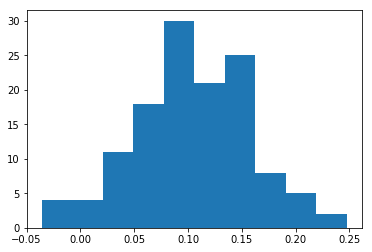

In [6]:
plt.hist(model.fc2.bias.detach());


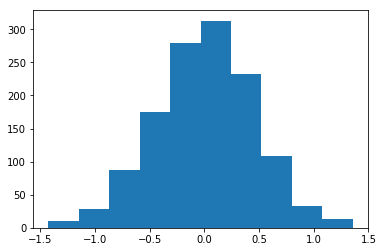

In [7]:
plt.hist(model.fc1.weight.flatten().detach());

In [8]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## I wish to change the batch size from 1 to N

In [14]:
# train network (show train and validation loss)
# save model when validation loss decreases
n_epochs = 100

valid_loss_min = np.Inf

for epochs in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    
    idx = np.arange(len(X_train))
    np.random.shuffle(idx)
    X_train = X_train[idx,:]
    D_train = D_train[idx]
    
    for N in range(len(X_train)):
        optimizer.zero_grad()
        data = X_train[N,:] 
        target = torch.from_numpy(D_train[N,:]).long()
        
        
        
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval()
    for N in range(len(X_valid)):
        data = X_valid[N,:]
        target = torch.from_numpy(D_valid[N,:]).long()
        
        output = model(data)
        loss = criterion(output, target) 
        valid_loss += loss.item()
        
    train_loss = train_loss/len(X_train)
    valid_loss = valid_loss/len(X_valid)
    
    print('Epoch: {}\t Train Loss {:6f}\t Valid Loss {:6f}'.format(
        epochs+1, train_loss, valid_loss))
    
    if valid_loss < valid_loss_min:
        print("val loss decreased. saving model")
        torch.save(model.state_dict(), 'RTC_model.pt')
        valid_loss_min = valid_loss

Epoch: 1	 Train Loss 0.310855	 Valid Loss 0.197020
val loss decreased. saving model
Epoch: 2	 Train Loss 0.297679	 Valid Loss 0.201093
Epoch: 3	 Train Loss 0.280050	 Valid Loss 0.181658
val loss decreased. saving model
Epoch: 4	 Train Loss 0.271091	 Valid Loss 0.177930
val loss decreased. saving model
Epoch: 5	 Train Loss 0.263744	 Valid Loss 0.173654
val loss decreased. saving model
Epoch: 6	 Train Loss 0.253353	 Valid Loss 0.177100
Epoch: 7	 Train Loss 0.251114	 Valid Loss 0.161351
val loss decreased. saving model
Epoch: 8	 Train Loss 0.241383	 Valid Loss 0.150589
val loss decreased. saving model
Epoch: 9	 Train Loss 0.236126	 Valid Loss 0.147743
val loss decreased. saving model
Epoch: 10	 Train Loss 0.228336	 Valid Loss 0.142358
val loss decreased. saving model
Epoch: 11	 Train Loss 0.228297	 Valid Loss 0.139789
val loss decreased. saving model
Epoch: 12	 Train Loss 0.219316	 Valid Loss 0.134530
val loss decreased. saving model
Epoch: 13	 Train Loss 0.213254	 Valid Loss 0.130901
val

## I need to load the pt file!!

In [15]:
## model loading

#model = RTC_net()
#model = load('')

In [52]:
# test data
test_loss = 0
test_accuracy = 0

model.eval()

prob_arr = np.zeros((len(X_test),3))
for N in range(len(X_test)):
    
    data = X_test[N,:]  
    target = torch.from_numpy(D_test[N]).long()

    output = model(data)  
    prob = F.softmax(output)
    ii = np.argmax(prob.detach().numpy(),axis=1)   
    test_accuracy += int(D_test[N]==ii)
    prob_arr[N,:] = prob.detach().numpy()
    loss = criterion(output, target)
    
    test_loss += loss.item()
test_loss = test_loss / len(X_test)
test_accuracy = test_accuracy / len(X_test)
      
print(test_loss)
print(test_accuracy*100)

C:\Users\Sejoon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.06355349056480467
97.36434108527132


## Let's VISUALIZE baby!

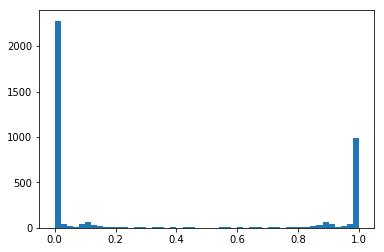

In [61]:
# visualize results
plt.hist(prob_arr.flatten(),bins=50);

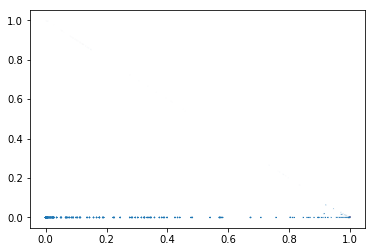

In [80]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
#ax = fig.add_subplot(111,projection='3d')
plt.scatter(prob_arr[:,0],prob_arr[:,1],prob_arr[:,2],marker='x')  

In [77]:
prob_arr[:,2]

array([7.68597238e-05, 1.04652420e-01, 1.89282335e-04, ...,
       9.99998212e-01, 1.00000000e+00, 9.98833239e-01])